In [56]:
import pandas as pd
import ast
import re
from collections import Counter
from difflib import SequenceMatcher
import matplotlib.pyplot as plt


In [57]:
all_data_ref = pd.read_parquet('all_data_ref_clean.parquet')

In [58]:
# in the references there is no 'ApJL', they appear as 'ApJ' that is why it is important to merge them with ApJ in journals
all_data_ref['journal'] = all_data_ref['journal'].replace('ApJL', 'ApJ')


In [59]:
all_data_ref.head(2)

,bibcode,my_keyword,first_author,n_authors,first_author_aff,first_author_aff_country_final_valid,year,read_count,citation_count,reference_journals,n_references,journal,SJR Best Quartile,grouped_keywords
0,1977JCoMa..11..395C,AI,"Christensen, R. M.",2,"California, University, Livermore, Calif",None,2024,0,4,"[JAM, JCoMa]",2,JCoMa,None,AI
1,2000A&A...353....1R,Cosmology,"Rebhan, E.",1,"Institut für Theoretische Physik, Heinrich-Hei...",Germany,2000,17,12,"[JETP, PhRv, SvPhU, JETPL, PhLB, PhRvL, PhLB, ...",27,A&A,Q1,Cosmology


In [60]:
all_data_ref['reference_journal_counts'] = all_data_ref['reference_journals'].apply(
    lambda x: dict(Counter(x)) 
)
all_data_ref['reference_journal_counts'].head(4)

0                               {'JAM': 1, 'JCoMa': 1}
1    {'JETP': 1, 'PhRv': 1, 'SvPhU': 1, 'JETPL': 2,...
2    {'ApJ': 12, 'MNRAS': 17, 'PhR': 1, 'nrfa': 1, ...
3    {'ApJ': 19, 'A&A': 13, 'MNRAS': 5, 'grle': 1, ...
Name: reference_journal_counts, dtype: object

In [61]:
def get_top_journals_by_keyword_contains(df, keyword_list, keyword_col='grouped_keywords', journal_col='journal', top_n=10):
    """
    Returns a wide-format DataFrame with the top N journals for each keyword substring match,
    including both journal names and their publication counts.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        keyword_list (list): List of keyword substrings to match (case-insensitive).
        keyword_col (str): Column name to search within for keyword substrings.
        journal_col (str): Column name containing journal names.
        top_n (int): Number of top journals to retrieve per keyword substring.

    Returns:
        pd.DataFrame: Wide-format DataFrame with journal names and counts for each matched keyword.
    """
    result_df = pd.DataFrame()

    for keyword in keyword_list:
        # Case-insensitive substring matching
        mask = df[keyword_col].str.contains(keyword, case=False, na=False)
        filtered = df[mask]

        top_journals = filtered[journal_col].value_counts().head(top_n)

        temp_df = pd.DataFrame({
            f"{keyword}_journal": top_journals.index,
            f"{keyword}_journal_count": top_journals.values
        })

        temp_df.reset_index(drop=True, inplace=True)
        result_df = pd.concat([result_df, temp_df], axis=1)

    return result_df
# Define your keyword patterns to look for (case-insensitive)
keywords_to_search = all_data_ref['grouped_keywords'].unique().tolist()
#keywords_to_search = ['exoplanet', 'star', 'AGN', 'Galaxy', 'Astrobiology', 'Asteroseismology']

top10_table = get_top_journals_by_keyword_contains(all_data_ref, keyword_col = 'grouped_keywords', keyword_list=keywords_to_search, top_n=10)
top_journals = get_top_journals_by_keyword_contains(all_data_ref, keyword_col = 'grouped_keywords', keyword_list=keywords_to_search, top_n=5)

top10_table.head(10)


,AI_journal,AI_journal_count,Cosmology_journal,Cosmology_journal_count,Astronomy_journal,Astronomy_journal_count,Astrobiology_journal,Astrobiology_journal_count
0,NatSR,10430,PhRvD,31193,ApJ,51238,NatSR,15513
1,Senso,8964,MNRAS,18721,MNRAS,36906,PNAS,12630
2,IEEEA,8276,ApJ,15930,A&A,33715,NatCo,5954
3,RemS,5321,JCAP,9825,AJ,9183,PhRvE,5057
4,PLoSO,3759,CQGra,8052,ApJS,3027,Bioin,4215
5,PatRe,3220,A&A,6737,Ap&SS,2969,PLoSO,3817
6,Heliy,2287,JHEP,6483,PASJ,2253,Natur,3399
7,CEAgr,2276,PhLB,4507,PhRvD,2173,JMoSt,2785
8,NatCo,1898,EPJC,4085,AN,2011,Heliy,2724
9,ApEn,1737,PhRvL,2902,PASP,1899,ESPR,2648


In [62]:
# Filter only the columns that contain journal names (not counts)
journal_columns = [col for col in top10_table.columns if col.endswith('_journal')]

# Flatten all journal names into one list
all_top_journals = pd.unique(top10_table[journal_columns].values.ravel())

# Drop NaNs and convert to a clean Python list
unique_top_journals = [j for j in all_top_journals if pd.notna(j)]

unique_top_journals_plus_sci = unique_top_journals + ['Sci', 'NatAs']

# Now `unique_top_journals` is your final list
print(unique_top_journals_plus_sci)
print(len(unique_top_journals_plus_sci))



['NatSR', 'PhRvD', 'ApJ', 'Senso', 'MNRAS', 'PNAS', 'IEEEA', 'A&A', 'NatCo', 'RemS', 'JCAP', 'AJ', 'PhRvE', 'PLoSO', 'CQGra', 'ApJS', 'Bioin', 'PatRe', 'Ap&SS', 'Heliy', 'JHEP', 'PASJ', 'Natur', 'CEAgr', 'PhLB', 'JMoSt', 'EPJC', 'AN', 'ApEn', 'PhRvL', 'PASP', 'ESPR', 'Sci', 'NatAs']
34


In [63]:
def add_reference_journal_columns(df, ref_col='reference_journal_counts', journal_list=None):
    """
    For each journal in `journal_list`, creates a new column in the DataFrame with the count
    of references to that journal from the dictionary column `ref_col`.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        ref_col (str): Name of the column containing dictionaries of journal reference counts.
        journal_list (list): List of journal names to extract counts for.

    Returns:
        pd.DataFrame: DataFrame with new columns added for each journal reference count.
    """
    if journal_list is None:
        raise ValueError("You must provide a list of journal names to extract.")

    for journal in journal_list:
        col_name = f"{journal}_ref_count"
        df[col_name] = df[ref_col].apply(
            lambda d: d.get(journal, 0) if isinstance(d, dict) else 0
        )

    return df


In [64]:
# Assuming unique_top_journals_plus_sci is your list of 33 journals
all_data_ref = add_reference_journal_columns(
    all_data_ref,
    ref_col='reference_journal_counts',
    journal_list=unique_top_journals_plus_sci
)


In [65]:
all_data_ref.head(4)

,bibcode,my_keyword,first_author,n_authors,first_author_aff,first_author_aff_country_final_valid,year,read_count,citation_count,reference_journals,...,PhLB_ref_count,JMoSt_ref_count,EPJC_ref_count,AN_ref_count,ApEn_ref_count,PhRvL_ref_count,PASP_ref_count,ESPR_ref_count,Sci_ref_count,NatAs_ref_count
0,1977JCoMa..11..395C,AI,"Christensen, R. M.",2,"California, University, Livermore, Calif",None,2024,0,4,"[JAM, JCoMa]",...,0,0,0,0,0,0,0,0,0,0
1,2000A&A...353....1R,Cosmology,"Rebhan, E.",1,"Institut für Theoretische Physik, Heinrich-Hei...",Germany,2000,17,12,"[JETP, PhRv, SvPhU, JETPL, PhLB, PhRvL, PhLB, ...",...,3,0,0,1,0,3,0,0,0,0
2,2000A&A...353...25M,"AGN, Cosmology, Galaxy","Miyaji, Takamitsu",3,Max-Planck-Inst. für extraterrestrische Physik...,Germany,2000,18,262,"[ApJ, ApJ, ApJ, ApJ, ApJ, ApJ, MNRAS, PhR, ApJ...",...,0,0,0,5,0,0,0,0,0,0
3,2000A&A...353...41S,"Cosmology, Galaxy","Schneider, Peter",3,"Max-Planck-Institut für Astrophysik, Postfach ...",Germany,2000,10,88,"[ApJ, A&A, ApJ, MNRAS, ApJ, MNRAS, grle, nrfa,...",...,0,0,0,0,0,0,0,0,0,0


In [66]:
all_data_ref_clean= all_data_ref[all_data_ref['first_author_aff_country_final_valid'] == all_data_ref['first_author_aff_country_final_valid']]
exoplanets = all_data_ref_clean[all_data_ref_clean['my_keyword'] == 'Exoplanet']


In [92]:
class JournalReferenceAnalyzer:
    def __init__(self, df, keyword_col='grouped_keywords', journal_col='journal'):
        self.df = df
        self.keyword_col = keyword_col
        self.journal_col = journal_col

    def journal_fraction_in_references(self, keyword_list, journal_name):
        journal_ref_col = f"{journal_name}_ref_count"
        results = []

        for keyword in keyword_list:
            sub_df = self.df[self.df[self.keyword_col] == keyword]
            sub_df = sub_df[sub_df['n_references'] > 0]

            n_articles_total = len(sub_df)

            if journal_ref_col in sub_df.columns and n_articles_total > 0:
                ref_fractions = sub_df[journal_ref_col] / sub_df['n_references']
                overall_fraction = ref_fractions.mean()
                overall_std = ref_fractions.std()
                overall_sem = overall_std / np.sqrt(n_articles_total)
            else:
                overall_fraction = None
                overall_std = None
                overall_sem = None

            sub_sub_df = sub_df[sub_df[self.journal_col] == journal_name]
            n_articles_from_journal = len(sub_sub_df)
            f_of_journal_field = (n_articles_from_journal / n_articles_total) if n_articles_total > 0 else None
            sem_f_of_journal_field = (np.sqrt(f_of_journal_field * (1 - f_of_journal_field) / n_articles_total)
                                      if f_of_journal_field is not None and n_articles_total > 0 else None)

            if journal_ref_col in sub_sub_df.columns and n_articles_from_journal > 0:
                ref_fractions_sub = sub_sub_df[journal_ref_col] / sub_sub_df['n_references']
                subset_fraction = ref_fractions_sub.mean()
                subset_std = ref_fractions_sub.std()
                subset_sem = subset_std / np.sqrt(n_articles_from_journal)
            else:
                subset_fraction = None
                subset_std = None
                subset_sem = None

            extra = (subset_fraction / overall_fraction) if overall_fraction and subset_fraction else None

            results.append({
                'keyword': keyword,
                'journal': journal_name,
                'n_articles_total': n_articles_total,
                'n_articles_from_journal': n_articles_from_journal,
                'f_of_journal_field': f_of_journal_field,
                'sem_f_of_journal_field': sem_f_of_journal_field,
                'mean_f_all_articles': overall_fraction,
                'std_f_all_articles': overall_std,
                'sem_f_all_articles': overall_sem,
                'mean_f_from_journal': subset_fraction,
                'std_f_from_journal': subset_std,
                'sem_f_from_journal': subset_sem,
                'journal_extra_citation_field': extra
            })

        return pd.DataFrame(results)

    def author_based_reference_bias(self, keyword, journal_name):
        journal_ref_col = f"{journal_name}_ref_count"

        sub_df = self.df[(self.df[self.keyword_col] == keyword) &
                         (self.df[self.journal_col] == journal_name)]

        author_keys = set(zip(sub_df['first_author'],
                              sub_df['first_author_aff_country_final_valid']))

        author_mask = self.df.apply(
            lambda row: (row['first_author'], row['first_author_aff_country_final_valid']) in author_keys,
            axis=1
        )

        author_articles = self.df[author_mask].copy()
        author_articles = author_articles[author_articles[self.keyword_col] == keyword]
        author_articles = author_articles[author_articles['n_references'] > 0]

        if journal_ref_col not in author_articles.columns or author_articles.empty:
            return pd.DataFrame([{
                "keyword": keyword,
                "journal": journal_name,
                "n_articles_total": 0,
                "n_in_journal": 0,
                "n_outside_journal": 0,
                "mean_f_in_journal": None,
                "std_f_in_journal": None,
                "sem_f_in_journal": None,
                "mean_f_outside_journal": None,
                "std_f_outside_journal": None,
                "sem_f_outside_journal": None,
                "journal_extra_citation": None
            }]), pd.DataFrame(), pd.DataFrame()

        author_articles['ref_fraction'] = author_articles[journal_ref_col] / author_articles['n_references']

        in_journal = author_articles[author_articles[self.journal_col] == journal_name]
        outside_journal = author_articles[author_articles[self.journal_col] != journal_name]

        mean_in = in_journal['ref_fraction'].mean()
        std_in = in_journal['ref_fraction'].std()
        sem_in = std_in / np.sqrt(len(in_journal)) if len(in_journal) > 0 else None

        mean_out = outside_journal['ref_fraction'].mean()
        std_out = outside_journal['ref_fraction'].std()
        sem_out = std_out / np.sqrt(len(outside_journal)) if len(outside_journal) > 0 else None

        extra = mean_in / mean_out if pd.notna(mean_in) and pd.notna(mean_out) and mean_out != 0 else None

        result_df = pd.DataFrame([{
            "keyword": keyword,
            "journal": journal_name,
            "n_articles_total": len(author_articles),
            "n_in_journal": len(in_journal),
            "n_outside_journal": len(outside_journal),
            "mean_f_in_journal": mean_in,
            "std_f_in_journal": std_in,
            "sem_f_in_journal": sem_in,
            "mean_f_outside_journal": mean_out,
            "std_f_outside_journal": std_out,
            "sem_f_outside_journal": sem_out,
            "journal_extra_citation": extra
        }])

        return result_df, in_journal, outside_journal

    def compare_field_and_author_bias(self, keyword, journal_list):
        summary_rows = []

        for journal in journal_list:
            field_df = self.journal_fraction_in_references([keyword], journal_name=journal)
            field_row = field_df.iloc[0] if not field_df.empty else {}

            author_df, _, _ = self.author_based_reference_bias(keyword, journal)
            author_row = author_df.iloc[0] if not author_df.empty else {}

            summary_rows.append({
                'keyword': keyword,
                'journal': journal,

                # Field-level
                'n_articles_total': field_row.get('n_articles_total'),
                'n_articles_from_journal': field_row.get('n_articles_from_journal'),
                'f_of_journal_field': field_row.get('f_of_journal_field'),
                'sem_f_of_journal_field': field_row.get('sem_f_of_journal_field'),
                'mean_f_all_articles': field_row.get('mean_f_all_articles'),
                'std_f_all_articles': field_row.get('std_f_all_articles'),
                'sem_f_all_articles': field_row.get('sem_f_all_articles'),
                'mean_f_from_journal': field_row.get('mean_f_from_journal'),
                'std_f_from_journal': field_row.get('std_f_from_journal'),
                'sem_f_from_journal': field_row.get('sem_f_from_journal'),
                'journal_extra_citation_field': field_row.get('journal_extra_citation_field'),

                # Author-level
                'n_articles_total_author': author_row.get('n_articles_total'),
                'n_in_journal_author': author_row.get('n_in_journal'),
                'n_outside_journal_author': author_row.get('n_outside_journal'),
                'mean_f_in_journal_author': author_row.get('mean_f_in_journal'),
                'std_f_in_journal_author': author_row.get('std_f_in_journal'),
                'sem_f_in_journal_author': author_row.get('sem_f_in_journal'),
                'mean_f_outside_journal_author': author_row.get('mean_f_outside_journal'),
                'std_f_outside_journal_author': author_row.get('std_f_outside_journal'),
                'sem_f_outside_journal_author': author_row.get('sem_f_outside_journal'),
                'journal_extra_citation_author': author_row.get('journal_extra_citation'),
            })

        return pd.DataFrame(summary_rows)

    def display_summary(self, df, decimals=3):
        return df.round(decimals)

In [93]:
astro_top_journal_list = top_journals['Astronomy_journal'].tolist() + ['Sci', 'Natur', 'NatAs']
#astro_top_journal_list = [j for j in astro_top_journal_list if j != 'ApJL']

In [103]:
all_data_ref_clean_10_years = all_data_ref_clean[all_data_ref_clean.year > 2014]

analyzer_all = JournalReferenceAnalyzer(all_data_ref_clean, keyword_col='grouped_keywords',)
comparison_df_all = analyzer_all.compare_field_and_author_bias(
    keyword="Astronomy",
    journal_list= astro_top_journal_list
)

all_data_ref_clean_5years = all_data_ref_clean[all_data_ref_clean.year > 2019]
analyzer_5years = JournalReferenceAnalyzer(all_data_ref_clean_5years, keyword_col='grouped_keywords',)
comparison_df_5years = analyzer_5years.compare_field_and_author_bias(
    keyword="Astronomy",
    journal_list= astro_top_journal_list
)


In [109]:
relevant_columns = ['journal', 
       'n_in_journal_author', 'n_outside_journal_author',
       'f_of_journal_field',  
       'mean_f_all_articles',
       'mean_f_in_journal_author',
       'mean_f_outside_journal_author',
       'journal_extra_citation_field',
       'journal_extra_citation_author']

summary_df_display = comparison_df_5years[relevant_columns].round(3)
summary_df_display

,journal,n_in_journal_author,n_outside_journal_author,f_of_journal_field,mean_f_all_articles,mean_f_in_journal_author,mean_f_outside_journal_author,journal_extra_citation_field,journal_extra_citation_author
0,ApJ,13189,5267,0.265,0.280,0.372,0.316,1.327,1.178
1,MNRAS,11956,4768,0.240,0.164,0.252,0.192,1.538,1.311
2,A&A,9017,2493,0.181,0.148,0.262,0.179,1.767,1.462
3,AJ,2456,1610,0.049,0.045,0.148,0.102,3.265,1.448
4,ApJS,999,1235,0.020,0.033,0.078,0.057,2.375,1.366
5,Sci,39,46,0.001,0.008,0.034,0.014,4.057,2.380
6,Natur,201,257,0.004,0.019,0.057,0.034,3.015,1.698
7,NatAs,353,508,0.007,0.006,0.017,0.014,3.055,1.244


In [105]:
from statsmodels.stats.proportion import proportion_confint

# Inputs:
# k = number of successes (e.g. articles in ApJ)
# n = total number of trials (e.g. all articles in Astronomy)
# method = 'wilson', 'agresti_coull', 'jeffreys', 'beta', 'binom_test', etc.
k = 50315
n = 175709
low, high = proportion_confint(count=k, nobs=n, alpha=0.32, method='wilson')
print (low, high)

0.28528288371306626 0.2874278059286713


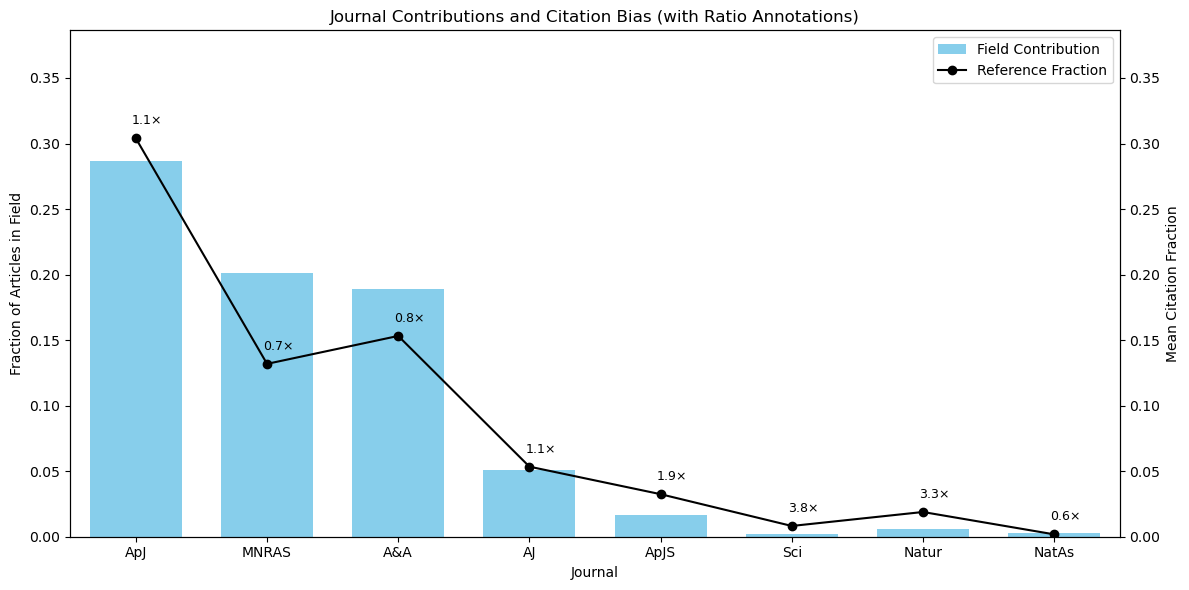

In [108]:
def plot_journal_contributions_and_bias(comparison_df, years = '5_years'):
    """
    Plots journal contributions to the field and citation bias metrics.
    
    Parameters:
        comparison_df (pd.DataFrame): DataFrame with columns:
            'journal', 'f_of_journal_field', 
            'mean_f_all_articles', 'mean_f_in_journal_author', 'mean_f_outside_journal_author'
    """
    # Prepare data
    journals = comparison_df["journal"].tolist()
    fractions = comparison_df["f_of_journal_field"].tolist()
    total = sum(fractions)
    other = 1 - total
    journals_with_other = journals # + ["Other"]
    fractions_with_other = fractions # + [other]

    # Compute citation-to-field ratios
    ratios_all = (comparison_df["mean_f_all_articles"] / comparison_df["f_of_journal_field"]).tolist()
    ratios_in = (comparison_df["mean_f_in_journal_author"] / comparison_df["f_of_journal_field"]).tolist()
    ratios_out = (comparison_df["mean_f_outside_journal_author"] / comparison_df["f_of_journal_field"]).tolist()

    # Plot setup
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for field contribution
    #
    # Adjust bar positions
    bar_width = 0.7
    bars = ax1.bar(journals_with_other, fractions_with_other, width=bar_width, color='skyblue', label='Field Contribution')

    ax1.set_ylabel('Fraction of Articles in Field')
    ax1.set_xlabel('Journal')
    ax1.set_title('Journal Contributions and Citation Bias (with Ratio Annotations)')
    ax1.set_xlim(-0.5, len(journals_with_other) - 0.5)
    ax1.set_ylim(0, max(fractions_with_other) + 0.1)

    for bar in bars:
        height = bar.get_height()
        #ax1.annotate(f"{height:.3f}", xy=(bar.get_x() + bar.get_width() / 3, height),
        #             xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    # Twin axis for citation lines
    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())

    x_ticks = range(len(comparison_df))

    line1 = ax2.plot(x_ticks, comparison_df["mean_f_all_articles"], marker='o', color='black', label='Reference Fraction')
    #line2 = ax2.plot(x_ticks, comparison_df["mean_f_in_journal_author"], marker='s', color='green', label='In-Journal Articles')
    #line3 = ax2.plot(x_ticks, comparison_df["mean_f_outside_journal_author"], marker='^', color='red', label='Outside-Journal Articles')
    ax2.set_ylabel('Mean Citation Fraction')

    # Annotate ratios
    for i, x in enumerate(x_ticks):
        ax2.annotate(f"{ratios_all[i]:.1f}×", xy=(x, comparison_df["mean_f_all_articles"].iloc[i]),
                     xytext=(8, 10), textcoords="offset points", ha='center', color='black', fontsize=9)
        #ax2.annotate(f"{ratios_in[i]:.1f}×", xy=(x, comparison_df["mean_f_in_journal_author"].iloc[i]),
        #             xytext=(10, 6), textcoords="offset points", ha='center', color='green', fontsize=9)
        #ax2.annotate(f"{ratios_out[i]:.1f}×", xy=(x, comparison_df["mean_f_outside_journal_author"].iloc[i]),
        #             xytext=(0, 6), textcoords="offset points", ha='center', color='red', fontsize=9)

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.tight_layout()
    plt.savefig(f"figures/journal_contributions_bias_{years}.png", dpi=300, bbox_inches='tight')  # or .pdf
    plt.show()


# Example usage:
plot_journal_contributions_and_bias(comparison_df_all, years = 'all')
